# Anomaly detection algorithms comparison

This example illustrates the properties of several anomaly detection algorithms for 2D datasets. To show the capacity of algorithms to handle multimodal data, datasets comprise one or two modes (regions of high density).

[scikit-learn documentation](https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_anomaly_comparison.html)

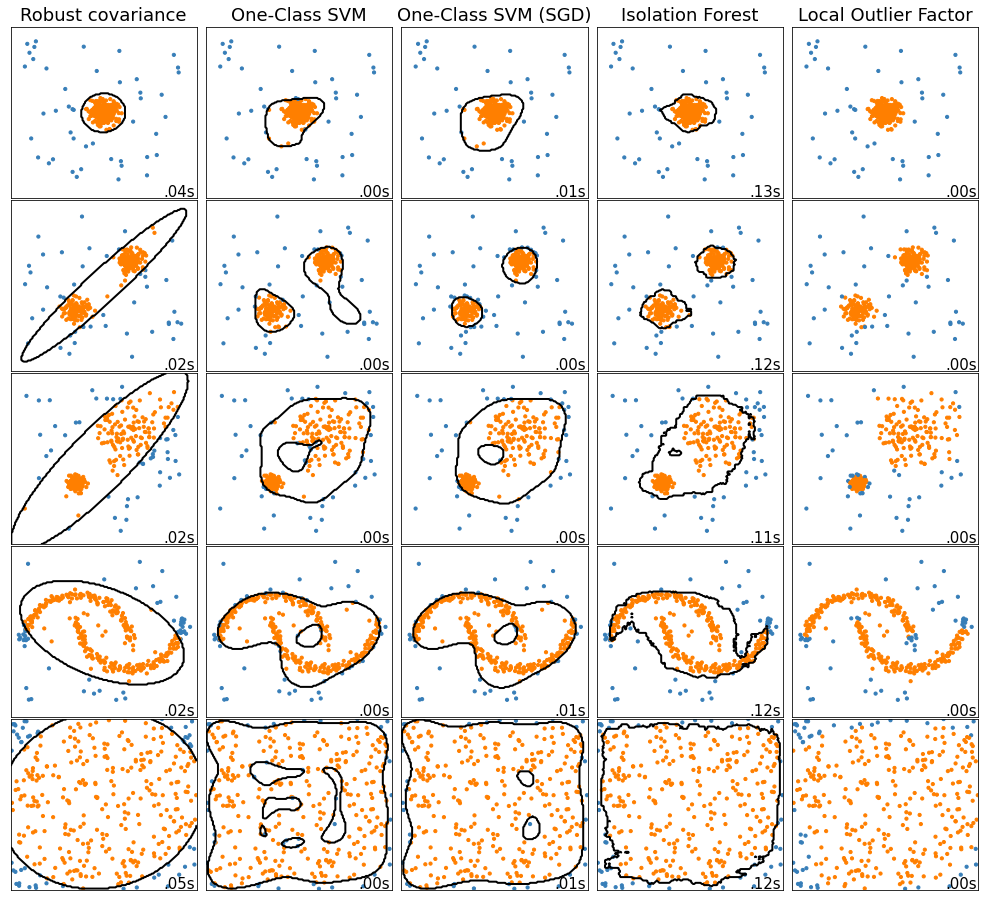

In [1]:
# Author: Alexandre Gramfort <alexandre.gramfort@inria.fr>
#         Albert Thomas <albert.thomas@telecom-paristech.fr>
# License: BSD 3 clause

import time

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.datasets import make_moons, make_blobs
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.linear_model import SGDOneClassSVM
from sklearn.kernel_approximation import Nystroem
from sklearn.pipeline import make_pipeline

matplotlib.rcParams["contour.negative_linestyle"] = "solid"

# Example settings
n_samples = 300
outliers_fraction = 0.15
n_outliers = int(outliers_fraction * n_samples)
n_inliers = n_samples - n_outliers

# define outlier/anomaly detection methods to be compared.
# the SGDOneClassSVM must be used in a pipeline with a kernel approximation
# to give similar results to the OneClassSVM
anomaly_algorithms = [
    ("Robust covariance", EllipticEnvelope(contamination=outliers_fraction)),
    ("One-Class SVM", svm.OneClassSVM(nu=outliers_fraction, kernel="rbf", gamma=0.1)),
    (
        "One-Class SVM (SGD)",
        make_pipeline(
            Nystroem(gamma=0.1, random_state=42, n_components=150),
            SGDOneClassSVM(
                nu=outliers_fraction,
                shuffle=True,
                fit_intercept=True,
                random_state=42,
                tol=1e-6,
            ),
        ),
    ),
    (
        "Isolation Forest",
        IsolationForest(contamination=outliers_fraction, random_state=42),
    ),
    (
        "Local Outlier Factor",
        LocalOutlierFactor(n_neighbors=35, contamination=outliers_fraction),
    ),
]

# Define datasets
blobs_params = dict(random_state=0, n_samples=n_inliers, n_features=2)
datasets = [
    make_blobs(centers=[[0, 0], [0, 0]], cluster_std=0.5, **blobs_params)[0],
    make_blobs(centers=[[2, 2], [-2, -2]], cluster_std=[0.5, 0.5], **blobs_params)[0],
    make_blobs(centers=[[2, 2], [-2, -2]], cluster_std=[1.5, 0.3], **blobs_params)[0],
    4.0
    * (
        make_moons(n_samples=n_samples, noise=0.05, random_state=0)[0]
        - np.array([0.5, 0.25])
    ),
    14.0 * (np.random.RandomState(42).rand(n_samples, 2) - 0.5),
]

# Compare given classifiers under given settings
xx, yy = np.meshgrid(np.linspace(-7, 7, 150), np.linspace(-7, 7, 150))

plt.figure(figsize=(len(anomaly_algorithms) * 2 + 4, 12.5))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.96, wspace=0.05, hspace=0.01
)

plot_num = 1
rng = np.random.RandomState(42)

for i_dataset, X in enumerate(datasets):
    # Add outliers
    X = np.concatenate([X, rng.uniform(low=-6, high=6, size=(n_outliers, 2))], axis=0)

    for name, algorithm in anomaly_algorithms:
        t0 = time.time()
        algorithm.fit(X)
        t1 = time.time()
        plt.subplot(len(datasets), len(anomaly_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        # fit the data and tag outliers
        if name == "Local Outlier Factor":
            y_pred = algorithm.fit_predict(X)
        else:
            y_pred = algorithm.fit(X).predict(X)

        # plot the levels lines and the points
        if name != "Local Outlier Factor":  # LOF does not implement predict
            Z = algorithm.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)
            plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors="black")

        colors = np.array(["#377eb8", "#ff7f00"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[(y_pred + 1) // 2])

        plt.xlim(-7, 7)
        plt.ylim(-7, 7)
        plt.xticks(())
        plt.yticks(())
        plt.text(
            0.99,
            0.01,
            ("%.2fs" % (t1 - t0)).lstrip("0"),
            transform=plt.gca().transAxes,
            size=15,
            horizontalalignment="right",
        )
        plot_num += 1

plt.show()

# Regressor comparison

A comparison of many scikit-learn regressors on synthetic datasets. Three one-dimensional datasets were created for this experiment: one linear, one polynomial, and one periodic. Then a forecast using each one using a variety of model types, ranging from linear regression to a deep neural network is explored.

[Source Code](https://gist.github.com/kwinkunks/48f86f4c368f5003d13dee734a16800c)

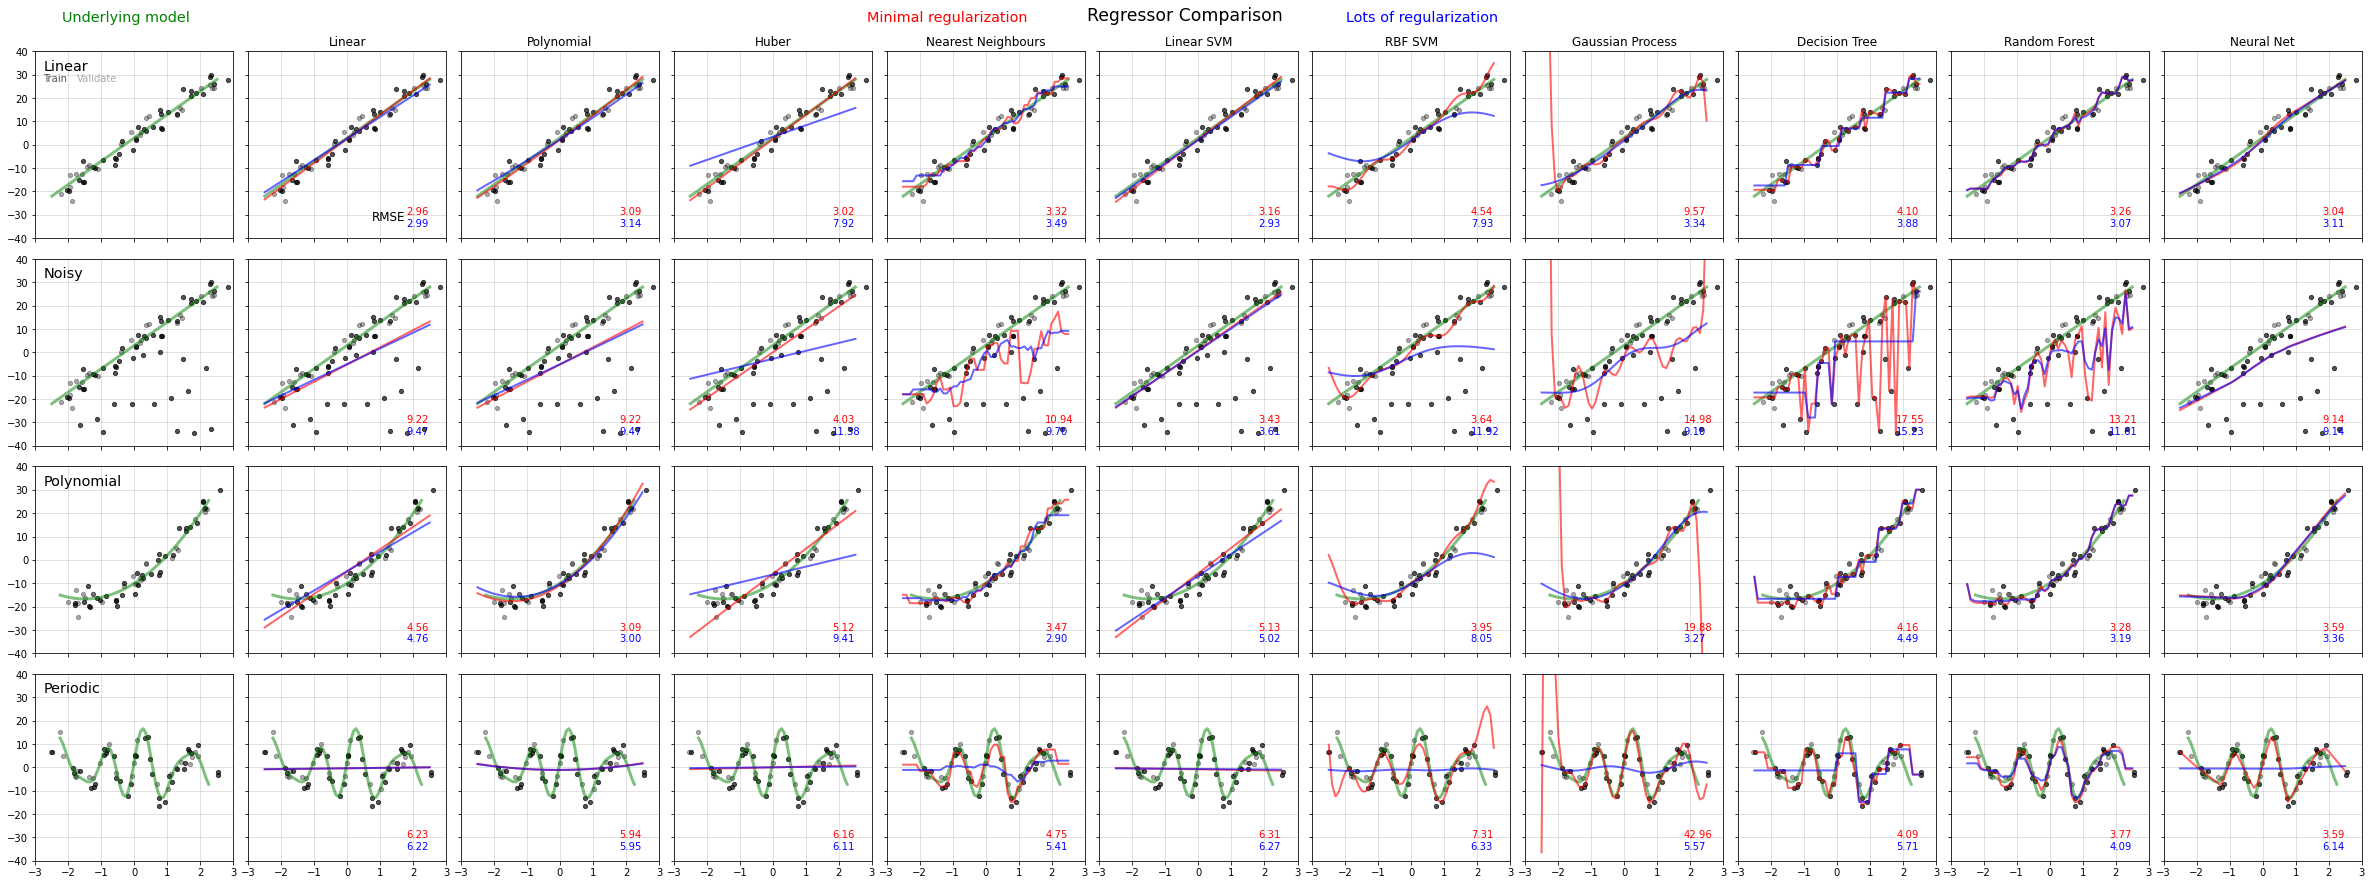

In [2]:
# Author: Matt Hall
# Email: matt@agilescientific.com
# License: BSD 3 clause
from sklearn.linear_model import Ridge, HuberRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt


def make_linear(N=50, noise=3, random_state=None, w=10, b=3):
    """Make x and y for a 1D linear regression problem."""
    def f(x, w, b):
        return w*x + b
    rng = np.random.default_rng(random_state)
    x = np.linspace(-2.5, 2.5, num=N) + rng.normal(0, noise/10, N)
    y = f(x, w, b) + rng.normal(0, noise, N)
    return x.reshape(-1, 1), y

def make_noisy(N=50, noise=3, random_state=None):
    xa, ya = make_linear(N=N, noise=noise, random_state=random_state)

    rng = np.random.default_rng(random_state)
    
    if noise:
        xn = np.linspace(-2.5, 2.5, num=N//2)
        yn = 70 * (0.5 - rng.random(size=N//2))
        xy = [[x, y] for x, y in zip(xn, yn) if y < 10*x -3]
        xb, yb = np.array(xy).T
    else:
        xb, yb = np.array([]), np.array([])

    return np.vstack([xa, xb.reshape(-1, 1)]), np.hstack([ya, yb])

def make_poly(N=50, noise=3, random_state=None):
    def f(x):
        return 3*x**2 + 9*x - 10
    rng = np.random.default_rng(random_state)
    x = np.linspace(-2.25, 2.25, num=N) + rng.normal(0, noise/10, N)
    y = f(x) + rng.normal(0, noise, N)
    return x.reshape(-1, 1), y

def make_periodic(N=50, noise=3, random_state=None):
    def f(x):
        return 10*np.sin(5*x) + 3*np.cos(3*x) + 5*np.sin(7*x)
    rng = np.random.default_rng(42)
    x = np.linspace(-2.25, 2.25, num=N) + rng.normal(0, noise/10, N)
    y = f(x) + rng.normal(0, noise, N)
    return x.reshape(-1, 1), y

def create_regression_datasets(N=50, noise=3, random_state=None):
    funcs = {
        'Linear': make_linear,
        'Noisy': make_noisy,
        'Polynomial': make_poly,
        'Periodic': make_periodic,
    }
    return {k: f(N, noise, random_state) for k, f in funcs.items()}

N = 60
random_state = 13

models = {
    '': dict(),
    'Linear': dict(model=Ridge(), pen='alpha', mi=0, ma=10),
    'Polynomial': dict(model=make_pipeline(PolynomialFeatures(2), Ridge()), pen='ridge__alpha', mi=0, ma=10),
    'Huber': dict(model=HuberRegressor(), pen='alpha', mi=0, ma=10),
    'Nearest Neighbours': dict(model=KNeighborsRegressor(), pen='n_neighbors', mi=3, ma=9),
    'Linear SVM': dict(model=SVR(kernel='linear'), pen='C', mi=1e6, ma=1),
    'RBF SVM': dict(model=SVR(kernel='rbf'), pen='C', mi=1e6, ma=1),
    'Gaussian Process': dict(model=GaussianProcessRegressor(random_state=random_state), pen='alpha', mi=1e-12, ma=1),
    'Decision Tree': dict(model=DecisionTreeRegressor(random_state=random_state), pen='max_depth', mi=20, ma=3),
    'Random Forest': dict(model=RandomForestRegressor(random_state=random_state), pen='max_depth', mi=20, ma=4),
    'Neural Net': dict(model=MLPRegressor(hidden_layer_sizes=(50, 50), max_iter=1000, tol=0.01, random_state=random_state), pen='alpha', mi=0, ma=10),    
}

datasets = create_regression_datasets(N=N, noise=3, random_state=random_state)
noiseless = create_regression_datasets(N=N, noise=0, random_state=0)

fig, axs = plt.subplots(nrows=len(datasets),
                        ncols=len(models),
                        figsize=(3*len(models), 3*len(datasets)),
                        sharex=True, facecolor='white'
                        )

label_rmse, label_train = True, True

for ax_row, (dataname, (x, y)), (_, (x_, y_)) in zip(axs, datasets.items(), noiseless.items()):
    for ax, (modelname, model) in zip(ax_row, models.items()):
        
        if dataname != 'Noisy':
            x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.4, random_state=random_state)
        else:
            x_sig, x_noise = x[:N], x[N:]
            y_sig, y_noise = y[:N], y[N:]
            x_train, x_val, y_train, y_val = train_test_split(x_sig, y_sig, test_size=0.4, random_state=random_state)            
            x_train = np.vstack([x_train, x_noise])
            y_train = np.hstack([y_train, y_noise])
            
        # Plot the noise-free case.
        ax.plot(x_, y_, c='g', alpha=0.5, lw=3)

        # Plot the training and validation data.
        ax.scatter(x_train, y_train, s=18, c='k', alpha=0.67)
        ax.scatter(x_val, y_val, s=18, c='k', alpha=0.33)

        if label_train:
            ax.text(-2.75, 27, f'Train', c='k', alpha=0.67)
            ax.text(-1.75, 27, f'Validate', c='k', alpha=0.33)
            label_train = False

        if (m := model.get('model')) is not None:
            
            xm = np.linspace(-2.5, 2.5).reshape(-1, 1)
            if (pen := model.get('pen')) is not None:
                m.set_params(**{pen: model['mi']})  # Min regularization.
            m.fit(x_train, y_train)
            ŷm = m.predict(xm)
            ax.plot(xm, ŷm, 'r', lw=2, alpha=0.6)

            ŷ = m.predict(x_val)
            mscore = np.sqrt(mean_squared_error(y_val, ŷ))
            ax.text(1.8, -30, f'{mscore:.2f}', c='r')
            
            if label_rmse:
                ax.text(0.75, -32.5, f'RMSE', c='k', fontsize='large')
                label_rmse = False       

        if (pen := model.get('pen')) is not None:
            m.set_params(**{pen: model['ma']})  # Max regularization.
            r = m.fit(x_train, y_train)
            ŷr = r.predict(xm)
            ax.plot(xm, ŷr, 'b', lw=2, alpha=0.6)

            ŷ = r.predict(x_val)
            rscore = np.sqrt(mean_squared_error(y_val, ŷ))
            ax.text(1.8, -35, f'{rscore:.2f}', c='b')
            
        ax.set_ylim(-40, 40)
        ax.set_xlim(-3, 3)

        if ax.get_subplotspec().is_first_row():
            ax.set_title(modelname)

        if ax.get_subplotspec().is_first_col():
            ax.text(-2.75, 32, f'{dataname}', c='k', fontsize='x-large')
        else:
            ax.set_yticklabels([])

        ax.grid(c='k', alpha=0.15)

plt.figtext(0.5, 1.0, 'Regressor Comparison', fontsize='xx-large', color='k', ha='center', va='bottom')
plt.figtext(0.0275, 1.0, 'Underlying model', fontsize='x-large', color='g', ha='left', va='bottom')
plt.figtext(0.4, 1.0, 'Minimal regularization', fontsize='x-large', color='red', ha='center', va='bottom')
plt.figtext(0.6, 1.0, 'Lots of regularization', fontsize='x-large', color='blue', ha='center', va='bottom')
plt.tight_layout()
plt.savefig('comparison.png', dpi=90)
plt.show()

# Classifier comparison

A comparison of many scikit-learn classifiers on simulated datasets. The purpose of this example is to highlight the decision thresholds of several classifiers. This should be interpreted with caution, since the understanding given by these examples may not necessarily apply to real-world datasets.

[scikit-learn Documentation](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html)

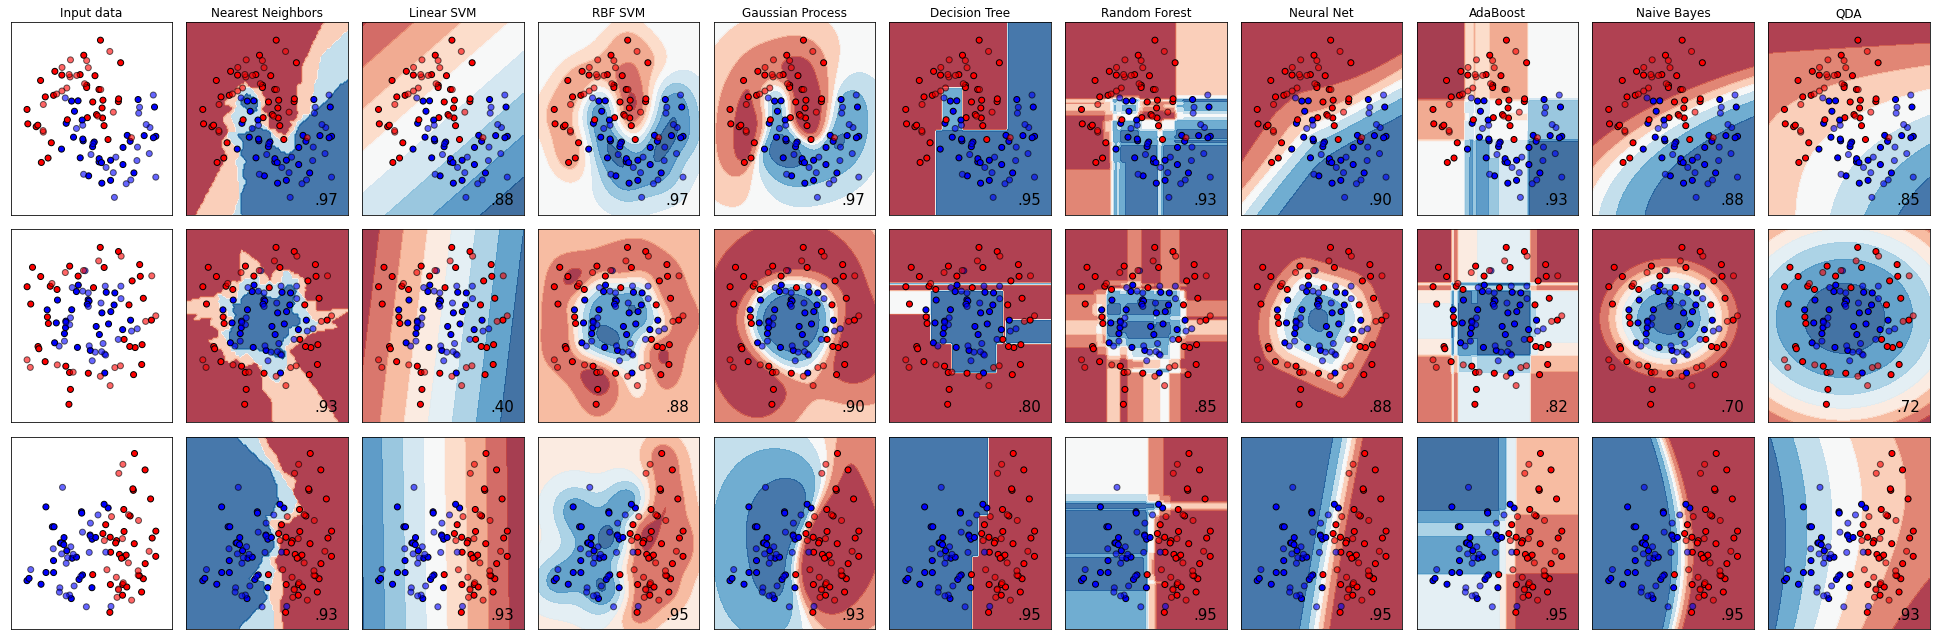

In [3]:
# Code source: Gaël Varoquaux
#              Andreas Müller
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.inspection import DecisionBoundaryDisplay

names = [
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Gaussian Process",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
    "QDA",
]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
]

X, y = make_classification(
    n_features=2, n_redundant=0, n_informative=2, random_state=1, n_clusters_per_class=1
)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [
    make_moons(noise=0.3, random_state=0),
    make_circles(noise=0.2, factor=0.5, random_state=1),
    linearly_separable,
]

figure = plt.figure(figsize=(27, 9))
i = 1
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.4, random_state=42
    )

    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(["#FF0000", "#0000FF"])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
    # Plot the testing points
    ax.scatter(
        X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors="k"
    )
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        DecisionBoundaryDisplay.from_estimator(
            clf, X, cmap=cm, alpha=0.8, ax=ax, eps=0.5
        )

        # Plot the training points
        ax.scatter(
            X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k"
        )
        # Plot the testing points
        ax.scatter(
            X_test[:, 0],
            X_test[:, 1],
            c=y_test,
            cmap=cm_bright,
            edgecolors="k",
            alpha=0.6,
        )

        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(
            x_max - 0.3,
            y_min + 0.3,
            ("%.2f" % score).lstrip("0"),
            size=15,
            horizontalalignment="right",
        )
        i += 1

plt.tight_layout()
plt.show()

# Clustering comparison

This example exhibits clustering techniques on "interesting" 2D datasets. Each dataset-algorithm pair, except for the final, has good clustering parameters. Some algorithms are parameter-sensitive. The final dataset is homogenous and has no decent grouping. The null dataset employs the same parameters as the dataset above it, which mismatches the parameter values and data structure. These examples offer method insight, although it may not apply to high-dimensional data.

[scikit-learn documentation](https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html)

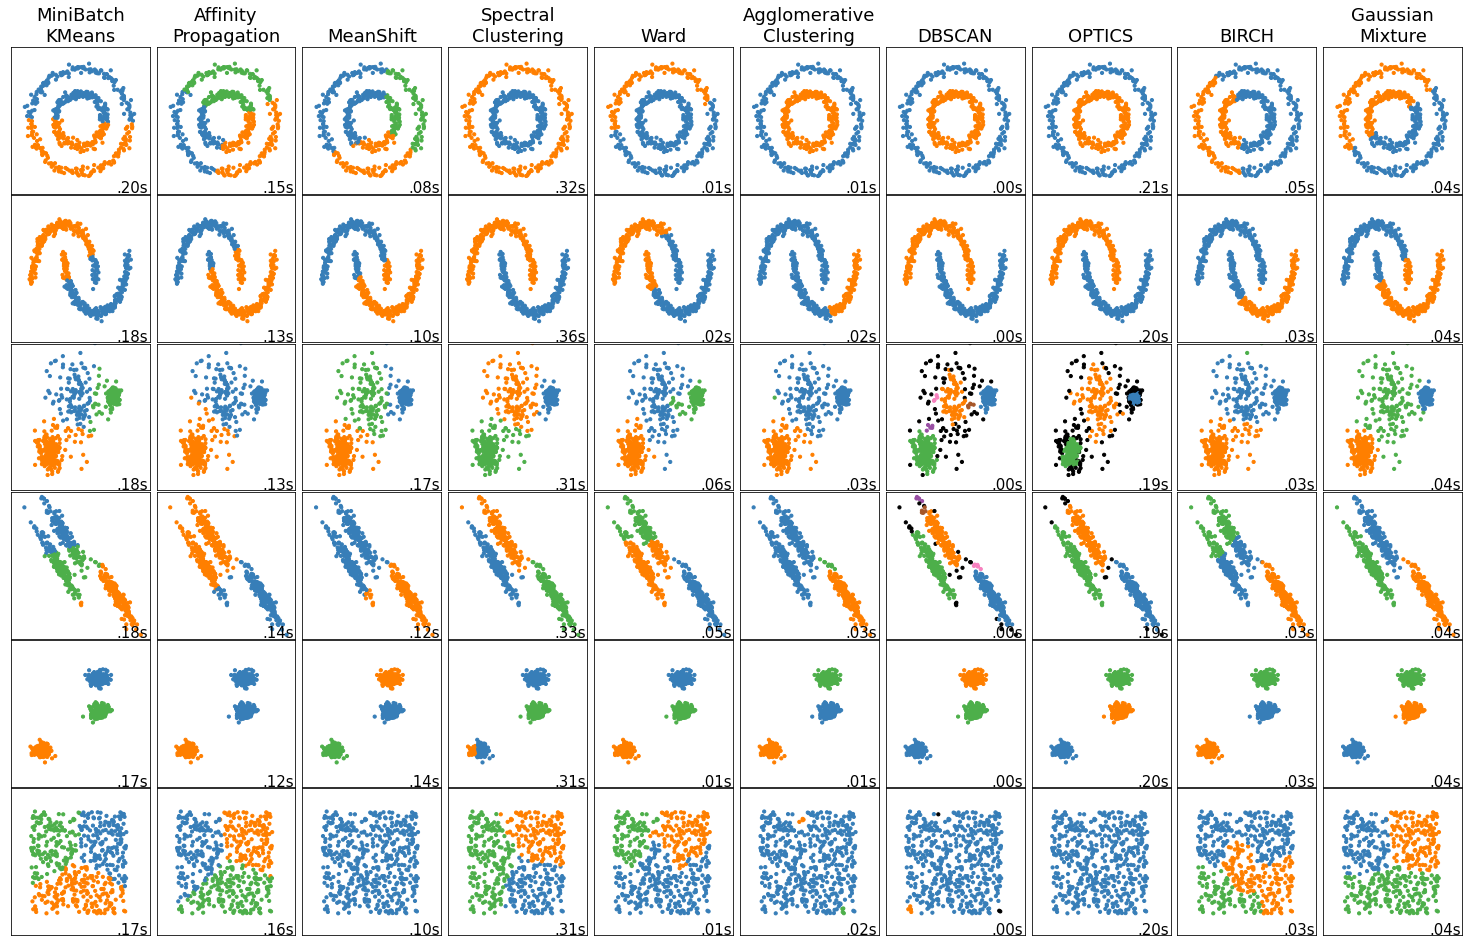

In [4]:
import warnings
warnings.filterwarnings('ignore')

import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

np.random.seed(0)

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=0.5, noise=0.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(
    n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state
)

# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(9 * 2 + 3, 13))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.95, wspace=0.05, hspace=0.01
)

plot_num = 1

default_base = {
    "quantile": 0.3,
    "eps": 0.3,
    "damping": 0.9,
    "preference": -200,
    "n_neighbors": 3,
    "n_clusters": 3,
    "min_samples": 7,
    "xi": 0.05,
    "min_cluster_size": 0.1,
}

datasets = [
    (
        noisy_circles,
        {
            "damping": 0.77,
            "preference": -240,
            "quantile": 0.2,
            "n_clusters": 2,
            "min_samples": 7,
            "xi": 0.08,
        },
    ),
    (
        noisy_moons,
        {
            "damping": 0.75,
            "preference": -220,
            "n_clusters": 2,
            "min_samples": 7,
            "xi": 0.1,
        },
    ),
    (
        varied,
        {
            "eps": 0.18,
            "n_neighbors": 2,
            "min_samples": 7,
            "xi": 0.01,
            "min_cluster_size": 0.2,
        },
    ),
    (
        aniso,
        {
            "eps": 0.15,
            "n_neighbors": 2,
            "min_samples": 7,
            "xi": 0.1,
            "min_cluster_size": 0.2,
        },
    ),
    (blobs, {"min_samples": 7, "xi": 0.1, "min_cluster_size": 0.2}),
    (no_structure, {}),
]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params["quantile"])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params["n_neighbors"], include_self=False
    )
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(n_clusters=params["n_clusters"])
    ward = cluster.AgglomerativeClustering(
        n_clusters=params["n_clusters"], linkage="ward", connectivity=connectivity
    )
    spectral = cluster.SpectralClustering(
        n_clusters=params["n_clusters"],
        eigen_solver="arpack",
        affinity="nearest_neighbors",
    )
    dbscan = cluster.DBSCAN(eps=params["eps"])
    optics = cluster.OPTICS(
        min_samples=params["min_samples"],
        xi=params["xi"],
        min_cluster_size=params["min_cluster_size"],
    )
    affinity_propagation = cluster.AffinityPropagation(
        damping=params["damping"], preference=params["preference"], random_state=0
    )
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average",
        affinity="cityblock",
        n_clusters=params["n_clusters"],
        connectivity=connectivity,
    )
    birch = cluster.Birch(n_clusters=params["n_clusters"])
    gmm = mixture.GaussianMixture(
        n_components=params["n_clusters"], covariance_type="full"
    )

    clustering_algorithms = (
        ("MiniBatch\nKMeans", two_means),
        ("Affinity\nPropagation", affinity_propagation),
        ("MeanShift", ms),
        ("Spectral\nClustering", spectral),
        ("Ward", ward),
        ("Agglomerative\nClustering", average_linkage),
        ("DBSCAN", dbscan),
        ("OPTICS", optics),
        ("BIRCH", birch),
        ("Gaussian\nMixture", gmm),
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the "
                + "connectivity matrix is [0-9]{1,2}"
                + " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning,
            )
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding"
                + " may not work as expected.",
                category=UserWarning,
            )
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, "labels_"):
            y_pred = algorithm.labels_.astype(int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(
            list(
                islice(
                    cycle(
                        [
                            "#377eb8",
                            "#ff7f00",
                            "#4daf4a",
                            "#f781bf",
                            "#a65628",
                            "#984ea3",
                            "#999999",
                            "#e41a1c",
                            "#dede00",
                        ]
                    ),
                    int(max(y_pred) + 1),
                )
            )
        )
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(
            0.99,
            0.01,
            ("%.2fs" % (t1 - t0)).lstrip("0"),
            transform=plt.gca().transAxes,
            size=15,
            horizontalalignment="right",
        )
        plot_num += 1

plt.show()